<h2>BMIF201 Lecture 2 in-class problem set instructions</h2>

This worksheet is intended to be completed in assigned groups of 2-3 in class. All members of each group should type their own solutions, but the solutions can be exactly identical. Feel free to ask other groups, the TAs, or the professor for assistance. Your homework for this unit will build upon the work that you do in these worksheets, so please make sure you complete them, during recitation if necessary.

None of the questions should require computations that take more than a few seconds, although it's OK if they take longer. If you find yourself waiting for a solution  to run, try using smaller simulation parameters.

You will modify the Wright-Fisher model you implemented last time to add the effect of selection, and verify several of the results that we learned today in lecture. First, open wright_fisher.py in your text editor and find the item marked TODO. One you've implemented it, you should be able to run the following two blocks without error.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class WrightFisher:
    mutation_rate: float
    population_size: int
    selection_coefficient: float

    # This is the function that is called when you write: model = WrightFisher(...)
    def __init__(self, mutation_rate: float, population_size: int, selection_coefficient: float = 0):
        self.mutation_rate = mutation_rate
        self.population_size = population_size
        self.selection_coefficient = selection_coefficient

    def next_generation(self, allele_frequencies: np.ndarray) -> np.ndarray:
        """
        :param allele_frequencies: array of allele frequencies in generation n
        :return: array of allele frequencies in generation n+1
        """

        expected_frequency = allele_frequencies.copy()  # avoid modifying input array

        # Effect of selection
        expected_frequency = (expected_frequency * (1 + self.selection_coefficient) /
                              (1 + expected_frequency * self.selection_coefficient))

        # Effect of mutation
        expected_frequency = (expected_frequency * (1 - self.mutation_rate) +
                              (1 - expected_frequency) * self.mutation_rate)

        # Effect of drift
        binomial_samples = np.random.binomial(2 * self.population_size, expected_frequency)

        return binomial_samples / (2 * self.population_size)

    def until_fixation(self, initial_allele_frequencies: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        :param initial_allele_frequencies: initial state
        :return: final allele frequencies (0/1-valued), time to fixation or loss
        """
        if self.mutation_rate > 0:
            raise ValueError("Mutation rate should be zero to analyze fixation")

        allele_frequencies = initial_allele_frequencies.copy()  # avoids modifying input array
        variants = np.where(allele_frequencies * (1 - allele_frequencies) > 0)[0]  # sites not yet fixed or lost
        time_to_fixation_or_loss = np.zeros_like(allele_frequencies, dtype=int)

        generations = 0
        while len(variants) > 0:
            generations += 1
            allele_frequencies[variants] = self.next_generation(allele_frequencies[variants])
            newly_fixed_variants = (allele_frequencies[variants] * (1 - allele_frequencies[variants]) == 0)
            time_to_fixation_or_loss[variants[newly_fixed_variants]] = generations
            variants = variants[~newly_fixed_variants]

        assert np.all(allele_frequencies * (1 - allele_frequencies) == 0)

        return allele_frequencies, time_to_fixation_or_loss


In [2]:
num_sites = 5
mutation_rate = 1e-1
selection_coefficient = 1e-1
population_size = 100
model = WrightFisher(mutation_rate, population_size, selection_coefficient)
generation_zero_frequency = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) 

np.random.seed(123)
generation_one_frequency = model.next_generation(generation_zero_frequency)
assert np.all(generation_one_frequency == np.array([0.205, 0.265, 0.39, 0.435, 0.47]))

<h5>Problem 1</h5>

Recall that in lecture, we derived that the fixation probability of a beneficial allele with selection coefficient s, beginning at an allele frequency of $1/2N$, is approximately $2s$. Verify that this is approximately true when $1/N << 2s << 1$. What happens when $2s < 1/N$, and when $2s>1$? Discuss with your partner why this makes sense.

In [3]:
num_sites = 10_000
mutation_rate = 0
selection_coefficient_array = [2**x for x in range(-12,2)]
population_size = 100
fixation_probability = [] 
for selection_coefficient in selection_coefficient_array:
    model = WrightFisher(mutation_rate, population_size, selection_coefficient)
    allele_frequency, _ = model.until_fixation(1/2/population_size * np.ones(num_sites))
    fixation_probability.append(np.mean(allele_frequency))

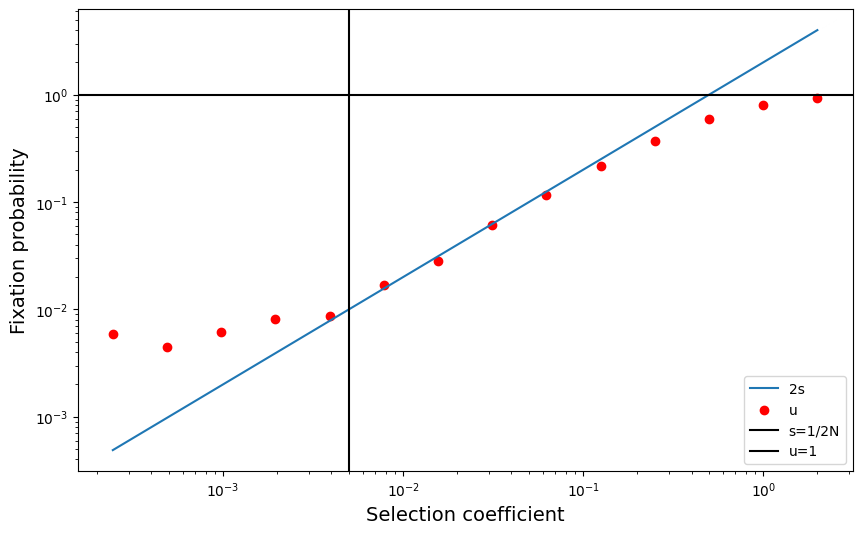

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(selection_coefficient_array, [2 * s for s in selection_coefficient_array])
plt.scatter(selection_coefficient_array, fixation_probability, color='red')
plt.axvline(x = 1 / (2 * population_size), color = 'black', label = '1/2N')
plt.axhline(y = 1, color = 'black', label = '1/2N')

plt.xlabel('Selection coefficient', fontsize=14)
plt.ylabel('Fixation probability', fontsize=14)
plt.legend(["2s", "u", "s=1/2N", "u=1"])
plt.xscale('log')
plt.yscale('log')

plt.show()

<h5>Problem 2</h5>

In medical genetics, it is often useful to know whether a human gene is "constrained", and in particular whether protein truncating variants (PTVs) in that gene show strong evidence of negative selection. (A PTV is an allele that completely ablates gene function, often by introducing a premature stop codon and triggering nonsense-mediated decay). In this problem, you will implement a simulations-based test for constraint. 

Suppose that you have genetic data for a population of size $N=1,000$. Moreover, there are $L=100$ sites at which a mutation could create a PTV (possibly, not all of which are observed in your data), each of which has a mutation rate of $\mu=10^{-7}$. All PTVs in the gene have the same selection coefficient, $s$, which is unknown.

Using simulations, you will compute the null distribution of a statistic that can be used to test for constraint.
1. Decide with your partner: what is an easily-computed statistic such that you expect it to be different when $s<<0$ vs. when $s=0$? (Multiple answers are possible, but I recommend computing something simple; the point is not to come up with something intuitive, not necessarily optimal). 
2. Simulate the null distribution for your statistic, with $s=0$. Plot a histogram of this distribution.
3. Simulate the non-null distribution for your statistic for a few values of $s<0$. For each non-null value of your statistic $X$, let $k_{smaller}$ be the number of null simulations whose statistic was less than or equal to $X$ out of $k_{total}$ in total. Compute the empirical p-value using the following formula:
$$\text{p-value} = \frac{1+k_{smaller}}{1+k_{total}}.$$
4. Plot the median p-value for each value of $s$. Discuss with your partner: what are the factors (besides $s$) that influence the statistical power of your test? Vary some of those factors and test your intuition.


In [5]:
num_sites = 100
mutation_rate = 0.001
population_size = 100

num_generations = population_size
def simulate_gene(selection_coefficient) -> np.ndarray:
    model = WrightFisher(mutation_rate, population_size, selection_coefficient)
    af = np.ones(num_sites) / population_size
    for i in range(num_generations):
        af = model.next_generation(af)
    return af

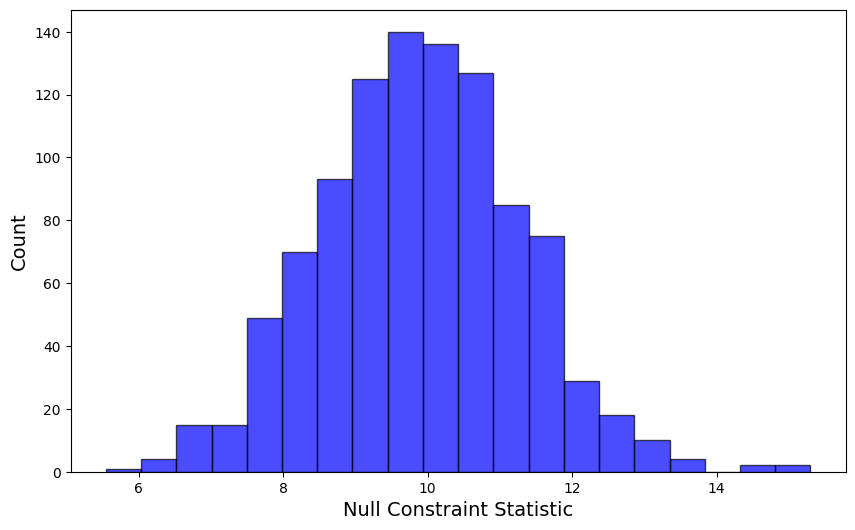

In [6]:
def constraint_statistic(allele_frequency):
    return np.sum(allele_frequency)

selection_coefficient = 0
null_constraint_statistics = []
num_genes = 1000
for gene in range(num_genes):
    allele_frequency = simulate_gene(selection_coefficient)
    null_constraint_statistics.append(constraint_statistic(allele_frequency))

plt.figure(figsize=(10, 6))
plt.hist(null_constraint_statistics, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Null Constraint Statistic', fontsize=14)
plt.ylabel('Count', fontsize=14)
pass

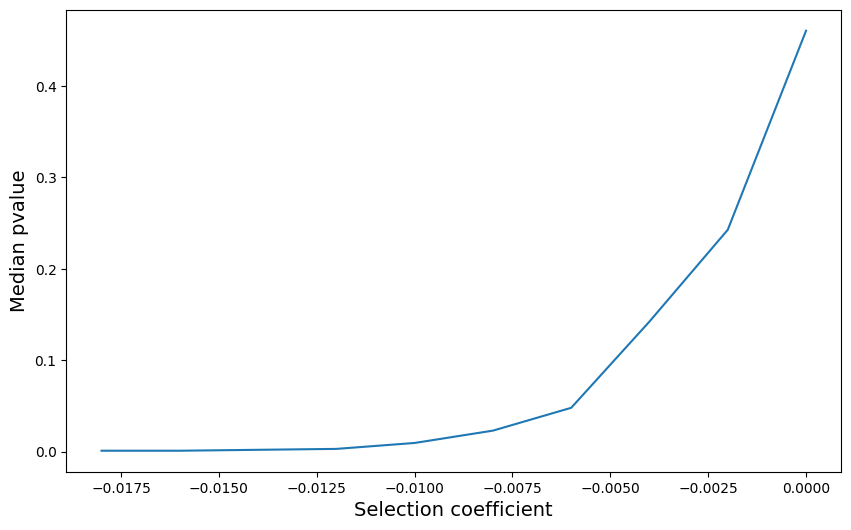

In [7]:
def empirical_pvalue(null_distribution, observed_statistic) -> float:
    return (1 + np.sum(null_distribution <= observed_statistic)) / (1 + len(null_distribution))
    
selection_coefficient_array = [-0.002 * i for i in range(10)]
median_pvals = []
num_genes = 100
for s in selection_coefficient_array:
    nonnull_constraint_statistics = []
    for gene in range(num_genes):
        allele_frequency = simulate_gene(s)
        nonnull_constraint_statistics.append(constraint_statistic(allele_frequency))
    p_values = [empirical_pvalue(null_constraint_statistics, x) for x in nonnull_constraint_statistics]
    median_pvals.append(np.median(p_values))

plt.figure(figsize=(10, 6))
plt.plot(selection_coefficient_array, median_pvals)

plt.xlabel('Selection coefficient', fontsize=14)
plt.ylabel('Median pvalue', fontsize=14)

plt.show()

<h3>Optional problems</h3>

If you finish the problems above early, please work on the following problem with your partner. 

<h5>Problem 3</h5>

We learned in lecture that the fixation time of a beneficial allele is much smaller than that of a neutral allele. Find the average fixation time for a few positive values of $s$. Next, find the fixation time of a deleterious allele having the same absolute selection coefficient: what do you notice? Discuss with your partner and try to get intuition for this phenomenon.

In [8]:
num_sites = 10_000_000 # needs to be large so that there are enough fixed sites even under negative selection
mutation_rate = 0
selection_coefficient_array = [0.005 * i for i in range(-4,5)]
population_size = 100
fixation_time = []
for selection_coefficient in selection_coefficient_array:
    model = WrightFisher(mutation_rate, population_size, selection_coefficient)
    allele_frequency, stopping_time = model.until_fixation(1/2/population_size * np.ones(num_sites))
    fixation_time.append(np.mean(stopping_time[allele_frequency == 1]))


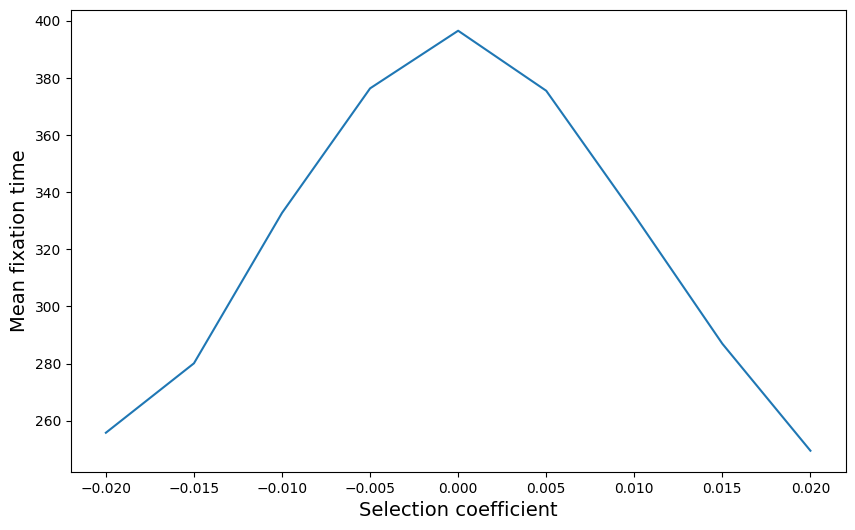

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(selection_coefficient_array, fixation_time)
plt.xlabel('Selection coefficient', fontsize=14)
plt.ylabel('Mean fixation time', fontsize=14)
plt.show()